# Get Sample Colors
> Get sample colors by using [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)

[Back to <b>contents</b>](../README.md)

First, represent the main colors of shoe in shoes.csv in 3D. <br>
Numpy, Matplotlib and csv libraries are needed

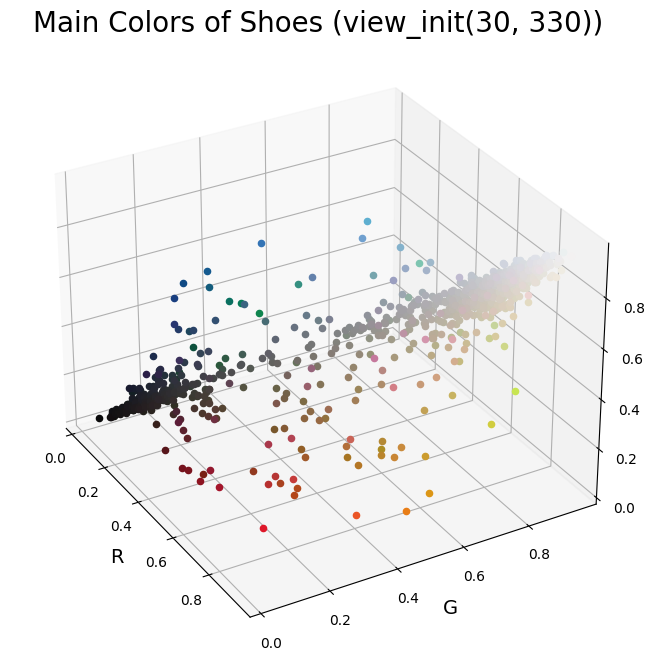

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline
def load_shoe_data(filename):
  class ShoeData:
    data = []
    target = []
    feature_names = ['Name','Brand','Colors','Link','wish','review']
  shoes = ShoeData()
  with open(filename,'r', encoding ='utf-8') as f:
    for items in csv.reader(f):
      if items[0].startswith('#'): continue
      shoes.target.append(eval(items[2]))
      shoes.data.append(items)
    shoes.data = np.array(shoes.data)
    return shoes

shoes = load_shoe_data('../data/shoes.csv')
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Main Colors of Shoes (view_init(30, 330))", size = 20)
ax.set_xlabel("R", size = 14)
ax.set_ylabel("G", size = 14)
ax.set_zlabel("B", size = 14)
for colors in shoes.target:
  RGBP = colors[0]
  RGB = np.array(RGBP[:-1])/255.0
  ax.scatter(RGB[0], RGB[1], RGB[2], color = RGB)
  
ax.view_init(30, 330)

Each view_init show plot by different angles.

<img src = "../img/MCS.png" width = 800vw>

### Data analysis
<div style ="backgroud-color : ">
1. As expected, the main colors of shoe are mostly achromatic.
2. <span style ="background-color : Black; color : white;">Black</span> and <span style ="background-color : White; color : Black;">white</span> are usually abundant, and the rest of the colors are evenly distributed.
</div>


## Goal
> I want to compress <b>color information</b> into <b>less number of colors</b>.
1. The above plots include only the main colors of shoe (1000 colors), so <span style = "color : red;">all colors of shoes are not used.</span>
2. A small number of colors should <mark>effeciently</mark> represent the color of the shoes.


In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sb

data = []
for colors in shoes.target:
  RGBP = colors[0]
  RGB = np.array(RGBP[:-1])/255.0
  data.append(RGB)
data
df = pd.DataFrame(columns=['R','G','B'], data=data)
df.head(10)

,R,G,B
0,0.854902,0.870588,0.878431
1,0.796078,0.800000,0.807843
2,0.203922,0.200000,0.196078
3,0.780392,0.800000,0.807843
4,0.874510,0.886275,0.890196
5,0.674510,0.682353,0.713725
6,0.635294,0.494118,0.341176
7,0.203922,0.200000,0.196078
8,0.513725,0.349020,0.203922
9,0.819608,0.831373,0.847059


In [3]:
df[['R','G','B']].std()

R    0.303231
G    0.300084
B    0.294923
dtype: float64

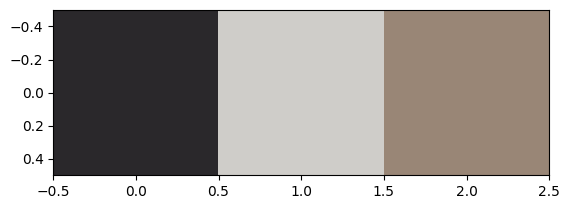

In [4]:
points = df.values
k = 3
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_
plt.imshow([centers])

In [5]:
df['cluster'] = kmeans.labels_
colors = []
for row in df['cluster']:
  colors.append(centers[row])
df['color'] = colors

df.head(10)

,R,G,B,cluster,color
0,0.854902,0.870588,0.878431,1,"[0.8155435354218311, 0.8073848696566746, 0.790..."
1,0.796078,0.800000,0.807843,1,"[0.8155435354218311, 0.8073848696566746, 0.790..."
2,0.203922,0.200000,0.196078,0,"[0.16491164366981398, 0.15988864681675186, 0.1..."
3,0.780392,0.800000,0.807843,1,"[0.8155435354218311, 0.8073848696566746, 0.790..."
4,0.874510,0.886275,0.890196,1,"[0.8155435354218311, 0.8073848696566746, 0.790..."
5,0.674510,0.682353,0.713725,1,"[0.8155435354218311, 0.8073848696566746, 0.790..."
6,0.635294,0.494118,0.341176,2,"[0.6020117137764196, 0.5288006111535524, 0.465..."
7,0.203922,0.200000,0.196078,0,"[0.16491164366981398, 0.15988864681675186, 0.1..."
8,0.513725,0.349020,0.203922,2,"[0.6020117137764196, 0.5288006111535524, 0.465..."
9,0.819608,0.831373,0.847059,1,"[0.8155435354218311, 0.8073848696566746, 0.790..."


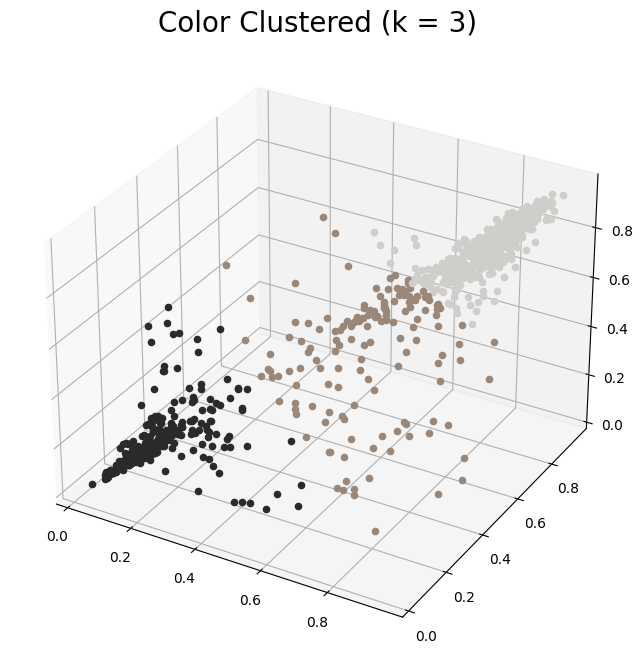

In [6]:
fig = plt.figure(figsize = (8, 8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.set_title(f"Color Clustered (k = {k})", size = 20)
for index, row in df.iterrows():
  ax2.scatter(row['R'], row['G'], row['B'], color = row['color'])
plt.show()

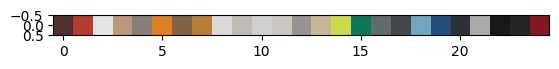

In [71]:
import colorsys
import math
k = 25
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.tolist()
# arr_2d = np.reshape(centers, (5,5,3))
# arr_2d.sort(key=lambda rgb: colorsys.rgb_to_hsv(*rgb))
centers.sort(key=lambda rgb: rgb[0] + rgb[1] + rgb[2])
plt.imshow([centers])

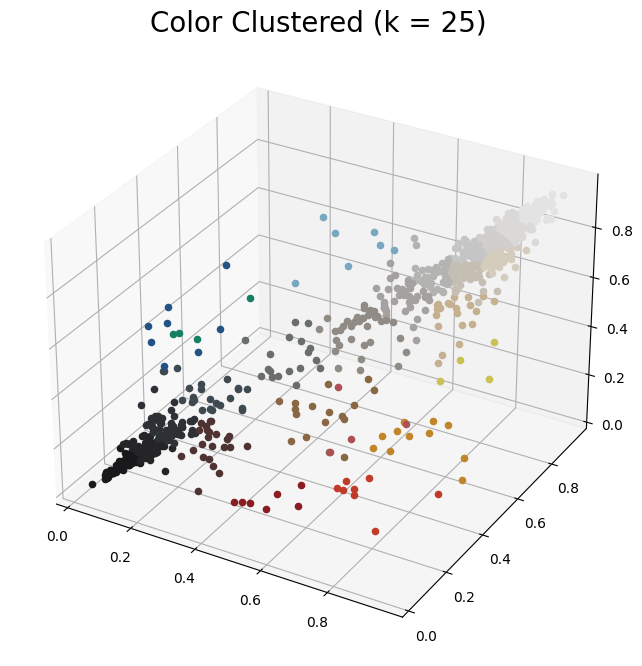

In [8]:
df['cluster'] = kmeans.labels_
colors = []
for row in df['cluster']:
  colors.append(centers[row])
df['color'] = colors
fig = plt.figure(figsize = (8, 8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.set_title(f"Color Clustered (k = {k})", size = 20)
for index, row in df.iterrows():
  ax2.scatter(row['R'], row['G'], row['B'], color = row['color'])
plt.show()

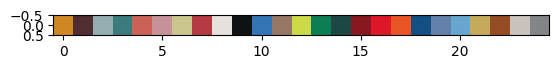

In [9]:
k = 500
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_
while k > 25 :
  k -= 5
  kmeans = KMeans(n_clusters = k).fit(centers)
  centers = kmeans.cluster_centers_
plt.imshow([centers])